
## PROYECTO INTELIGENCIA ARTIFICIAL 2019-2

# Proyección de costos de la atención hospitalaria en Bucaramanga por accidentes de tránsito

Evaluaremos datos que contienen costos promedios de accidentes de transito de enero 2018 a octubre 2019. Se encuentran datos como tipo de vehículo, relación al conductor, sexo, fecha del siniestro, EPS y demás datos importantes. Datos provistos por https://www.datos.gov.co/, Datos Abiertos, Gobierno de Colombia.

Dataset: https://www.datos.gov.co/Salud-y-Protecci-n-Social/Costos-de-la-atenci-n-hospitalaria-en-Bucaramanga-/g4vd-w4ip

Estudiantes: 

*   Jonattan Stivent Vargas Camacho - 2142612
*   Jonathan Buitrago - 2163024

Referencias en el Dataset: https://www.datos.gov.co/, derechos reservados.

In [0]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/ai-uis-student/notebooks
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive/ai-uis-student/notebooks'
/content/drive/My Drive/ai-uis-student/notebooks
/content/drive/My Drive/ai-uis-student/notebooks


In [0]:
from __future__ import division, print_function, unicode_literals #py2 and py3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import *

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow import keras
import os
import sys

from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN


### **PROPÓSITO DEL PROYECTO: Prestar un servicio para predecir con la mayor exactitud posible el costo de la atención hospitalaria de un accidente de transito en B/ga**

#####**NUESTRO DATASET INICIALMENTE**

In [0]:
d = pd.read_csv("../data/costos_atencion_hospitalaria.csv")

pd.set_option('display.width', 500)
pd.set_option('precision', 5)
pd.set_option('display.max_columns',25)

print( "Dimensión de los datos:", d.shape)
print(d.head(9))


Dimensión de los datos: (19643, 24)
   Numero  EDAD GRUPO ETAREO  CURSO DE VIDA       SEXO TIPO DE VEHÍCULO RELACION USUARIO/ACCIDENTE   FECHA DE ACCIDENTE HORA DE ACCIDENTE DIA ACCIDENTE DIA SEMANA ACCIDENTE MES ACCIDENTE AÑO ACCIDENTE REQUERIMIENTO DE CX REFERIDO A OTRA IPS CONDICION EGRESO         COSTOS                      EPS USUARIO FECHA DE INGRESO IPS HORA DE INGRESO IPS DIA DE INGRESO IPS DIA SEMANA DE INGRESO IPS MES DE INGRESO IPS ANO INGRESO IPS
0       1    68     60 y mas  Persona Mayor  Masculino             Moto                  Conductor  07/01/2018 18:00:00            18: 00            07              domingo         Enero          2018                  No                  No             Vivo     $   60,125                    COMPARTA LTDA  10/01/2018 00:00:00            00:00:00                 10                 miércoles              Enero            2018
1       2    25      19 a 28        Jovenes   Femenino             Moto                  Conductor  01/01/2018

### **PROCESAMIENTO DE DATOS Y PREPARACIÓN DE LA INFORMACIÓN**

Se cuentan con los siguientes datos dados por el Gobierno de Colombia en su programa Open Data para que una persona introduzca sus valores personales usando nuestro proyecto para predecir el costo que tendria su accidente con sus variables introducidas.


1. EDAD
2. GENERO
3. TIPO_DE_VEHICULO, tipo de vehiculo que se accidenta
4. RELACION_USUARIO_ACCIDENTE, relacion de la persona afectada con el accidente
5. DIA_SEMANA_ACCIDENTE
6. MES_DEL_ACCIDENTE
7. CIRUGIA, requerimiento y necesidad de cirugia (Boolean: SI, NO)
8. REFERIDO_A_OTRA_IPS, Requerimiento y necesidad de referir a otra IPS (Boolean: SI, NO)
9. CONDICION_EGRESO (Boolean: VIVO, MUERTO)
10. COSTO_MEDICO, valor de las atenciones medicas
11. EPS, Eps del accidentado
12. DIA_SEMANA_INGRESO_IPS, si no hay informacion se dira "Sin información"
13. MES_INGRESO_IPS, si no hay informacion se dira ""Sin información"

######**El principal objetivo es predecir el valor de COSTO_MÉDICO**

Eliminamos las columnas que no nos servirán ya que el introducirlas no es necesariamente ADECUADO, NI PERTINENTE, NI TIENE PROPÓSITO para el Sistema de información por parte de una persona que tiene el fin predecir el costo que tendría su supuesto accidente, como por ejemplo FECHA_DE_ACCIDENTE

*Recordar que la información en todo Sistema de información debe tener las propiedades de Pertinencia y Propósito*

In [0]:
del d["Numero"], d['GRUPO ETAREO'], d['CURSO DE VIDA'], d['FECHA DE ACCIDENTE'], d['HORA DE ACCIDENTE'], d['DIA ACCIDENTE'], d['AÑO ACCIDENTE'] 
del d['FECHA DE INGRESO IPS'], d['HORA DE INGRESO IPS'], d['DIA DE INGRESO IPS'], d['ANO INGRESO IPS']

d.rename(columns={'TIPO DE VEHÍCULO':'TIPO_DE_VEHÍCULO','RELACION USUARIO/ACCIDENTE':'RELACION_USUARIO_ACCIDENTE',
                  'DIA SEMANA ACCIDENTE':'DIA_SEMANA_ACCIDENTE','MES ACCIDENTE':'MES_DEL_ACCIDENTE','REQUERIMIENTO DE CX':'CIRUGIA',
                  'REFERIDO A OTRA IPS':'REFERIDO_A_OTRA_IPS','CONDICION EGRESO':'CONDICION_EGRESO','COSTOS':'COSTO_MÉDICO',
                  'EPS USUARIO':'EPS','DIA SEMANA DE INGRESO IPS':'DIA_SEMANA_INGRESO_IPS',
                  'MES DE INGRESO IPS':'MES_INGRESO_IPS'},inplace=True)

print( "Dimensión de los datos:", d.shape)
print(d.head(3))


Dimensión de los datos: (19643, 13)
   EDAD       SEXO TIPO_DE_VEHÍCULO RELACION_USUARIO_ACCIDENTE DIA_SEMANA_ACCIDENTE MES_DEL_ACCIDENTE CIRUGIA REFERIDO_A_OTRA_IPS CONDICION_EGRESO COSTO_MÉDICO                  EPS DIA_SEMANA_INGRESO_IPS MES_INGRESO_IPS
0    68  Masculino             Moto                  Conductor              domingo             Enero      No                  No             Vivo   $   60,125        COMPARTA LTDA              miércoles           Enero
1    25   Femenino             Moto                  Conductor                lunes             Enero      No                  No             Vivo  $   112,061  LIBERTY SEGUROS S.A                 martes           Enero
2    20  Masculino             Moto                  Conductor            miércoles             Enero      No                  No             Vivo   $   54,751  LIBERTY SEGUROS S.A              miércoles           Enero


#####**Tenemos alrededor de 19.000 registros con multiples edades, excelente para nuestro ejercicio de predicción**

In [0]:
d["EDAD"].unique()

array([ 68,  25,  20,  17,  29,  34,  22,  23,  31,  28,  42,  33,  26,
        14,  24,  30,  35,  36,  50,  27,  37,  21,  54,  15,  44,  38,
        18,  43,  58,  19,   6,  78,  46,  48,  12,  52,  32,  51,  16,
        41,  67,  56,   8,  13,   5,   3,  40,  45,  47,  49,  55,  57,
        39,  59,  73,  61,  60,  53,  72,  74,  63,  64,  80,  66,   4,
         2,  10,  65,   1,  70,  62,  11,  82,  79,  84,  77,   7,  69,
        85,  76,   9,  87,  75,  71,  86,  81, 118,  83,  88,  89,  92,
        90, 107,  91,  96, 101])

Observamos las siguientes columnas y realizamos el debido procesamiento de los datos para obtener la adecuada información

In [0]:
d["SEXO"].unique()

array(['Masculino', 'Femenino'], dtype=object)

Para trabajar nuestros metodos de prediccion, debemos convertir los valores String a numericos

In [0]:
d['SEXO'] = d['SEXO'].replace({'Masculino':0,'Femenino':1 })

In [0]:
d["TIPO_DE_VEHÍCULO"].unique()

array(['Moto', 'Carro', 'Bus', 'Camión', 'Bicicleta', 'Sin información',
       'Peatón', 'Camioneta', 'No aplica', 'Ciclista', 'BUS'],
      dtype=object)

In [0]:
d['TIPO_DE_VEHÍCULO'] = d['TIPO_DE_VEHÍCULO'].replace({'BUS' : 'Bus'})

In [0]:
 len(d[(d.TIPO_DE_VEHÍCULO == 'Sin información')])

1390

No podemos trabajar con registros que contengan "Sin informacion", y no podemos completarlos con promedios para no corromper los datos y predecir con la mayor FIABILIDAD para el importante caso de predecir este valor

In [0]:
d = d[(d['TIPO_DE_VEHÍCULO'] != 'Sin información')]

In [0]:
d['TIPO_DE_VEHÍCULO'] = d['TIPO_DE_VEHÍCULO'].replace({'Moto':0,'Carro':1,'Bus':2,'Camión':3,'Bicicleta':4,'Peatón':5,'Camioneta':6,'No aplica':7,
                                                       'Ciclista':8 })

In [0]:
d["RELACION_USUARIO_ACCIDENTE"].unique()

array(['Conductor', 'Peatón', 'Pasajero', 'Ocupante', 'Sin información',
       'Ciclista', 'OCUPANTE', 'CICLISTA'], dtype=object)

In [0]:
d['RELACION_USUARIO_ACCIDENTE'] = d['RELACION_USUARIO_ACCIDENTE'].replace({'OCUPANTE' : 'Ocupante','CICLISTA' : 'Ciclista'})

In [0]:
len(d[(d.RELACION_USUARIO_ACCIDENTE == 'Sin información')])

10

In [0]:
d = d[(d['RELACION_USUARIO_ACCIDENTE'] != 'Sin información')]

In [0]:
d['RELACION_USUARIO_ACCIDENTE'] = d['RELACION_USUARIO_ACCIDENTE'].replace({'Conductor':0,'Peatón':1,'Pasajero':2,'Ocupante':3,'Ciclista':4})

In [0]:
d["DIA_SEMANA_ACCIDENTE"].unique()

array(['domingo', 'lunes', 'miércoles', 'viernes', 'sábado', 'martes',
       'jueves', '01/06//2018', '02/06//2018', '03/06//2018',
       '04/06//2018', '05/06//2018', '06/06//2018', '08/06//2018',
       '09/06//2018', '10/06//2018', '11/06//2018', '12/06//2018',
       '13/06//2018', '14/06//2018', '15/06//2018', '16/06//2018',
       '17/06//2018', '18/06//2018', '19/06//2018', '20/06//2018',
       '21/06//2018', '22/06//2018', '23/06//2018', '24/06//2018',
       '25/06//2018', '26/06//2018', '27/06//2018', '28/06//2018',
       '29/06//2018'], dtype=object)

In [0]:
d = d[(d['DIA_SEMANA_ACCIDENTE'] == 'domingo') | (d['DIA_SEMANA_ACCIDENTE'] =='lunes') | 
                              (d['DIA_SEMANA_ACCIDENTE'] =='martes') | (d['DIA_SEMANA_ACCIDENTE'] =='miércoles') |
                              (d['DIA_SEMANA_ACCIDENTE'] =='jueves') | (d['DIA_SEMANA_ACCIDENTE'] =='viernes') |
                              (d['DIA_SEMANA_ACCIDENTE'] =='sábado')]

In [0]:
d["DIA_SEMANA_ACCIDENTE"].unique()

array(['domingo', 'lunes', 'miércoles', 'viernes', 'sábado', 'martes',
       'jueves'], dtype=object)

In [0]:
d['DIA_SEMANA_ACCIDENTE'] = d['DIA_SEMANA_ACCIDENTE'].replace({'domingo':0,'lunes':1,'miércoles':2,'viernes':3,'sábado':4,'martes':5,'jueves':6})

In [0]:
d["MES_DEL_ACCIDENTE"].unique()

array(['Enero', 'Febrero', 'Diciembre', 'Noviembre', 'Mayo', 'Septiembre',
       'Octubre', 'Marzo', 'Julio', 'Agosto', 'Abril', 'Junio',
       'septiembre', 'octubre', 'noviembre', 'diciembre'], dtype=object)

In [0]:
d['MES_DEL_ACCIDENTE'] = d['MES_DEL_ACCIDENTE'].replace({'septiembre':'Septiembre','octubre':'Octubre','noviembre':'Noviembre','diciembre':'Diciembre'})

In [0]:
d['MES_DEL_ACCIDENTE'] = d['MES_DEL_ACCIDENTE'].replace({'Enero':0,'Febrero':1,'Marzo':2,'Abril':3,'Mayo':4,'Junio':5,'Julio':6,'Agosto':7,
                                                       'Septiembre':8,'Octubre':9,'Noviembre':10,'Diciembre':11})

In [0]:
d["CIRUGIA"].unique()

array(['No', 'Si', '-'], dtype=object)

In [0]:
len(d[(d.CIRUGIA == '-')])

4

In [0]:
d = d[(d['CIRUGIA'] != '-')]

In [0]:
d['CIRUGIA'] = d['CIRUGIA'].replace({'No':0,'Si':1})

In [0]:
d["REFERIDO_A_OTRA_IPS"].unique()

array(['No', 'Si'], dtype=object)

In [0]:
d['REFERIDO_A_OTRA_IPS'] = d['REFERIDO_A_OTRA_IPS'].replace({'No':0,'Si':1})

In [0]:
d["CONDICION_EGRESO"].unique()

array(['Vivo', 'Muerto'], dtype=object)

In [0]:
d['CONDICION_EGRESO'] = d['CONDICION_EGRESO'].replace({'Vivo':0,'Muerto':1})

In [0]:
d["COSTO_MÉDICO"].unique()

array(['$   60,125', '$   112,061', '$   54,751', ..., '$   247,120',
       '$   816,244', '$   223,177'], dtype=object)

In [0]:
d = d[(d['COSTO_MÉDICO'] != '-') & (d['COSTO_MÉDICO'] != '$   -') & (d['COSTO_MÉDICO'] != 'nan') & (d['COSTO_MÉDICO'] != 'ERROR: #N/A')]

In [0]:
len(d[d['COSTO_MÉDICO'].isnull() == True])

92

Nos damos cuenta que ahi datos que aunque no son nan se configuran asi, debemos eliminarlos

In [0]:
d = d[d['COSTO_MÉDICO'].isnull() == False]

In [0]:
len(d["COSTO_MÉDICO"])

13412

In [0]:
l = d["COSTO_MÉDICO"].values

In [0]:
v=[]
for i in range(len(l)):
  v.append(l[i])

In [0]:
print(type(l))
print(type(v))

<class 'numpy.ndarray'>
<class 'list'>


#####Validamos de que no se este configurando ningun valor diferente a STRING en la columna COSTO_MÉDICO, si se encuentra otro es una anormalidad, por ejemplo, si es FLOAT puede haber un dato NaN, asi esto es para volver los valores tipo INT

In [0]:
lista = []
for i in range(len(v)):
  lista.append(type(v[i]))

In [0]:
lista_c = set(lista)

In [0]:
lista_c

{str}

In [0]:
print(v)

['$   60,125', '$   112,061', '$   54,751', '$   444,924', '$   55,132', '$   62,438', '$   67,755', '$   70,062', '$   1,488,547', '$   57,097', '$   53,760', '$   68,887', '$   76,247', '$   54,990', '$   58,928', '$   57,497', '$   58,557', '$   58,928', '$   52,827', '$   57,988', '$   51,300', '$   189,322', '$   4,674,650', '$   76,459', '$   65,577', '$   61,682', '$   170,283', '$   74,325', '$   103,787', '$   84,522', '$   58,683', '$   146,461', '$   70,850', '$   91,920', '$   53,367', '$   462,652', '$   65,157', '$   118,550', '$   132,420', '$   52,577', '$   57,497', '$   1,250,671', '$   51,300', '$   84,855', '$   56,267', '$   45,100', '$   92,201', '$   76,596', '$   50,025', '$   3,925,939', '$   50,467', '$   185,465', '$   3,979,993', '$   11,350,371', '$   57,807', '$   3,501,473', '$   522,878', '$   56,711', '$   6,083,640', '$   94,375', '$   56,028', '$   126,820', '$   71,602', '$   226,174', '$   143,957', '$   64,389', '$   529,596', '$   53,367', '$   10

In [0]:
w=[]
for m in range(len(v)):
  p=0
  z=0
  h=0
  p = v[m].replace("$   ","")
  z = p.replace(",","")
  h = int(z)
  w.append(h)

In [0]:
print(w)

[60125, 112061, 54751, 444924, 55132, 62438, 67755, 70062, 1488547, 57097, 53760, 68887, 76247, 54990, 58928, 57497, 58557, 58928, 52827, 57988, 51300, 189322, 4674650, 76459, 65577, 61682, 170283, 74325, 103787, 84522, 58683, 146461, 70850, 91920, 53367, 462652, 65157, 118550, 132420, 52577, 57497, 1250671, 51300, 84855, 56267, 45100, 92201, 76596, 50025, 3925939, 50467, 185465, 3979993, 11350371, 57807, 3501473, 522878, 56711, 6083640, 94375, 56028, 126820, 71602, 226174, 143957, 64389, 529596, 53367, 100994, 111770, 52577, 77016, 69167, 61069, 58986, 62287, 4855137, 56805, 57667, 67687, 53843, 119238, 60212, 52180, 126509, 180579, 9723375, 59669, 58557, 75652, 72600, 132802, 113797, 57497, 6367911, 66072, 58557, 60890, 75780, 55979, 57651, 64019, 59913, 52311, 57097, 52180, 6861501, 51300, 139253, 71074, 45100, 57712, 111069, 256522, 119063, 222751, 172432, 101000, 60815, 73025, 61743, 69123, 161631, 128911, 437601, 383879, 236856, 55090, 196873, 191982, 170807, 7686016, 91374, 1410

In [0]:
d["COSTO_MÉDICO"] = w

In [0]:
d["EPS"].unique()

array(['COMPARTA LTDA', 'LIBERTY SEGUROS S.A',
       'SEGUROS COMERCIALES BOLIVAR S.A', 'LA PREVISORA S.A',
       'SURAMERICANA DE SEGUROS S.A.', 'QBE SEGUROS S.A',
       'ADMINISTRADORA DE LOS RECURSOS SGSS  ADRES', 'SEGUROS DEL ESTADO',
       'COOMEVA EPS', 'ASEGURADORA SOLIDARIA DE COLOMBIA',
       'COMPAÑIA MUNDIAL DE SEGUROS S.A. - SEGUROS MUNDIAL',
       'NUEVA EPS S.A', 'AXA COLPATRIA SEGUROS S.A', nan,
       'COOSALUD ENTIDAD PROMOTORA DE SALUD S.A.', 'MEDIMAS EPS S.A.S.',
       'SALUD TOTAL EPS-S S.A.', 'CAFESALUD EPS Y EPSS',
       'E.P.S. SANITAS S.A.', 'EPS Y MEDICINA PREPAGADA SURAMERICANA S.A',
       'NUEVA EMPRESA PROMOTORA DE SALUD EPS', 'COOMEVA E.P.S. S.A',
       'DIRECCION GENERAL DE SANIDAD MILITAR', 'EPS FAMISANAR SAS',
       'COOSALUD ESS SANTANDER', 'SALUDCOOP EPS O.C.',
       'ASOCIACION MUTUAL LA ESPERANZA ASMETSALUD ESS',
       'FUNDACION OFTALMOLOGICA DE SANTANDER CLINICA CARLOS ARDILA L',
       'SECCIONAL DE SANIDAD SANTANDER', 'SALUD VIDA E.P

Se consulta en m.dateas.com, https://www.supersalud.gov.co/es-co/Paginas/Protecci%C3%B3n%20al%20Usuario/InstitucionesMapa/mapaPutumayo.html, https://docs.supersalud.gov.co/PortalWeb/Jurisdiccional/Conciliacion/COFL03-(003)-CUCUTA.pdf los numeros a que EPS corresponde, se halla que son NIT

In [0]:
d['EPS'] = d['EPS'].replace({'800130907':'SALUD TOTAL EPS','900156264':'NUEVA EPS','804002105':'COMPARTA LTDA','805000427':'COOMEVA EPS','817000248':'ASMET SALUD',
                            '800251440':'E.P.S. SANITAS','900226715':'COOSALUD ENTIDAD PROMOTORA DE SALUD S.A.','830003564':'FAMISANAR EPS','800088702':'EPS Y MEDICINA PREPAGADA SURAMERICANA S.A',
                             '8300741845':'SALUD VIDA EPS','890201213':'CAPRUIS','830039670':'HOSPITAL NAVAL DE CARTAGENA','800050068':'FUNDACION MEDICO PREVENTIVA',
                             '890201235':'SECRETARIA DE SALUD DE SANTANDER'})

In [0]:
d = d[(d['EPS'] != '801097473') & (d['EPS'] != '-289192747') & (d['EPS'] != '804012088') & (d['EPS'] != 'nan') & (d['EPS'] != 'XX XXX XX UNIONXXXXXXX NO UTILIZAR') & (d['EPS'] != '-') & (d['EPS'] != 'ERROR: #N/A') & (d['EPS'] != 'Sin información') & (d['EPS'] != 'SD')]

In [0]:
d = d[d['EPS'].isnull() == False]

In [0]:
d['EPS'] = d['EPS'].replace({'COMPARTA LTDA':0, 'COOPERATIVA DE SALUD COMUNITARIA EPS SUBSIDIADA COMPARTA EPS':0, 
                              'COMPARTA ARS':1,
                              'LIBERTY SEGUROS S.A':2,'LIBERTY SEGUROS DE VIDA S.A.':2,'LIBERTY SEGUROS S.A.':2, 'LIBERTY SEGUROS DE VIDA S.A':2,
                              'SEGUROS COMERCIALES BOLIVAR S.A':3,'COMPAÑIA DE SEGUROS BOLIVAR S.A.':3, 'SEGUROS BOLIVAR S.A':3,
                              'LA PREVISORA S.A':4,
                              'SURAMERICANA DE SEGUROS S.A.':5,'COMPAÑIA SURAMERICANA DE SEGUROS':5,'SEGUROS DE VIDA SURAMERICANA S.A.':5,
                              'COMPAÑIA SURAMERICANA DE SEGUROS':5,'SEGUROS DE VIDA SURAMERICANA S.A':5,'CIA.SURAMERICANA DE SEGUROS DE VIDA S.A.':5,
                              'EPS Y MEDICINA PREPAGADA SURAMERICANA S.A':6, 'EPS SURA':6, 
                              'ARL SURA S.A (SURATEP)':7,'QBE SEGUROS S.A':8,'ADMINISTRADORA DE LOS RECURSOS SGSS  ADRES':9,
                              'SEGUROS DEL ESTADO':10,'SEGUROS DE VIDA DEL ESTADO S.A.':11,
                              'COOMEVA EPS':12,'COOMEVA E.P.S. S.A':12,'COOMEVA E.P.S.':12,'EPS COOMEVA':12,
                              'ASEGURADORA SOLIDARIA DE COLOMBIA':13,'ASEGURADORA SOLIDARIA DE COLOMBIA ENTIDAD COOPERATIVA':14,
                              'COMPAÑIA MUNDIAL DE SEGUROS S.A. - SEGUROS MUNDIAL':15,'COMPAÅƒIA MUNDIAL DE SEGUROS S.A. - SEGUROS MUNDIAL':15,
                              'COMPAŃIA MUNDIAL DE SEGUROS S.A. - SEGUROS MUNDIAL':15,
                              'NUEVA EPS S.A':16, 'NUEVA EMPRESA PROMOTORA DE SALUD EPS':16,'NUEVA EPS':16,
                              'AXA  COLPATRIA SEGUROS DE VIDA  S.A.':17,'AXA COLPATRIA SEGUROS S.A':17,'AXA COLPATRIA SEGUROS DE VIDA S.A.':17,
                              'AXA COLPATRIA SEGUROS  S.A.':17,'AXA COLPATRIA MEDICINA PREPAGADA S.A.':18,
                              'COOSALUD ENTIDAD PROMOTORA DE SALUD S.A.':19,'COOSALUD ESS SANTANDER':19,
                              'MEDIMAS EPS S.A.S.':20,'MEDIMAS EPS':20,
                              'SALUD TOTAL EPS-S S.A.':21,'SALUD TOTAL':21,'SALUD TOTAL EPS':21,
                              'CAFESALUD EPS Y EPSS':22,'CAFESALUD EPS':22,
                              'E.P.S. SANITAS S.A.':23,'E.P.S. SANITAS':23,'ENTIDAD PROMOTORA DE SALUD SANITAS SAS':23,
                              'COOMEVA MEDICINA PREPAGADA S.A.':24,'COOMEVA MEDICINA PREPAGADA':24,
                              'DIRECCION GENERAL DE SANIDAD MILITAR':25,'DIR GRAL SDAD MILITAR BASE 5':25,
                              'EPS FAMISANAR SAS':26,'FAMISANAR EPS':26,
                              'SALUDCOOP EPS O.C.':27,
                              'ASOCIACION MUTUAL LA ESPERANZA ASMETSALUD ESS':28,'ASMET SALUD EPS SAS':28,'ASMET SALUD':28,
                              'FUNDACION OFTALMOLOGICA DE SANTANDER CLINICA CARLOS ARDILA L':29,
                              'SECCIONAL DE SANIDAD SANTANDER':30,'POLICIA SECCIONAL SANIDAD SANTANDER':30,'SECCIONAL SANIDAD SANTANDER POLICIA NACIONAL':30,
                              'POLICIA NACIONAL DEPARTAMENTO DE SANIDAD DEL CESAR':31,
                              'SALUD VIDA E.P.S. S.A.':32,'SALUD VIDA EPS':32,'SALUD VIDA':32,
                              'EMPRESA MUTUAL PARA EL DESARROLLO INTEGRAL DE LA SALUD ESS':33, 'MUTUAL SER EPS':33,
                              'SALUD COLPATRIA S.A.':34,
                              'SECRETARIA DE SALUD DE SANTANDER':35,
                              'SERVICIO NACIONAL DE APRENDIZAJE SENA REGIONAL SANTANDER':36,
                              'FUNDACION OFTAMOLOGICA SANTANDER':37,
                              'SOLSALUD E.P.S. DEL REGIMEN CONTRIBUTIVO Y SUBSIDIADO':38,
                              'SALUD VIDA ARS':39,
                              'EMDISALUD':40,
                              'COLSANITAS S.A.':41,
                              'FUNDACION MEDICO PREVENTIVA':42,
                              'FUNDACION CARDIOVASCULAR DE COLOMBIA':43,
                              'LA EQUIDAD SEGUROS GENERALES ORGANISMO COOPERATIVO':44,'LA EQUIDAD SEGUROS DE VIDA ORGANISMO COOPERATIVO':44,
                              'COMPENSAR E.P.S':45,
                              'CAJA DE COMPENSACION FAMILIAR COMPENSAR':46,
                              'ALIANZA OPERATIVA S.A.S':47,
                              'MAPFRE SEGUROS GENERALES DE COLOMBIA S.A':48,'MAPFRE COLOMBIA VIDA SEGUROS S.A':48,
                              'RED SALUD ATENCION HUMANA E.P.S.':49,
                              'U.T. RED INTEGRADA FOSCAL - CUB':50,'UNION TEMPORAL UT RED INTEGRADA FOSCAL-CUB':50, 
                              'UROMEDICA LTDA':51,
                              'COMFENALCO ANTIOQUIA':52,
                              'CAJA DE COMPENSACION FAMILIAR COMFENALCO SANTANDER':53,
                              'UNION TEMPORAL AVANZAR MEDICO REGION 1':54,'UT AVANZAR MEDICO REGION UNO':54,
                              'UNION TEMPORAL AVANZAR MEDICO':55,
                              'POSITIVA COMPAÑIA DE SEGUROS':56,'POSITIVA COMPAÑIA DE SEGUROS S.A.':56,'POSITIVA COMPAÅƒIA DE SEGUROS S.A.':57,
                              'SEGUROS DE RIESGOS PROFESIONALES SURAMERICANA':58,'SEGUROS DE RIESGOS LABORALES SURAMERICANA SA':58,
                              'CID CENTRO INTEGRAL DE DIAGNOSTICO Y DESARROLLO IPS E.U.':59,
                              'ALIANSALUD EPS':60,
                              'PARTICULAR':61,'PARTICULARES':61,
                              'ECOPETROL':62,'ECOPETROL S.A.':62,'ECOPETROL SA':62,
                              'MEDISANITAS S.A. COMPAÑIA DE MEDICINA PREPAGADA':63,
                              'CAPRESOCA':64,
                              'ENTIDAD PROMOTORA DE SALUD DEL REGIMEN SUBSIDIADO EPSS CONVI':65,
                              'CAPRUIS':66,'UNIVERSIDAD INDUSTRIAL DE SANTANDER':66,
                              'HOSPITAL NAVAL DE CARTAGENA':67,
                              'COLMEDICA MEDICINA PREPAGADA S.A.':69,
                              'ALLIANZ SEGUROS DE VIDA S.A.':70,
                              'BAVARIA S.A.':71,
                              'COLMENA VIDA ARP':72,
                              'COMPAÑIA DE SEGUROS DE VIDA COLMENA':73,
                              'CRUZ BLANCA E.P.S.':74,
                              'CLINICA PIEDECUESTA':75,
                              'EPS-S AMBUQ ESS':76,
                              'CAJA DE COMPENSACION FAMILIAR CAJACOPI ATLANTICO':77,
                              'FUNDACION SALUD MIA EPS':78,
                              'LABORAL SALUD IPS S.A.S':79,
                              'NO REPORTA':80
                              })

In [0]:
d["DIA_SEMANA_INGRESO_IPS"].unique()

array(['miércoles', 'martes', 'lunes', 'viernes', 'sábado', 'domingo',
       'jueves', nan, '07: 00', '07: 30', '16: 30', '05: 20', '16: 46',
       '11: 30', '15: 45', '19: 00', '14: 40', '19: 20', '22: 50',
       '21: 00', '07: 20', '17: 20', '21: 20', '07: 50', '20: 30',
       '13: 45', '08: 20', '18: 10', '01: 30', '18: 00', '09: 00',
       '00: 40', '09: 30', '15: 30', '05: 30', '10: 30', '13: 15',
       '16: 00', '04: 00', '16: 20', '14: 00', '11: 00', '08: 00',
       '13: 40', '08: 45', '04: 50', '18: 30', '05: 00', '06: 15',
       '05: 50', '10: 00', '15: 00', '00: 00', '15: 50', '18: 55',
       '12: 00', '06: 00', '13: 58', '12: 30', '19: 30'], dtype=object)

In [0]:
d = d[(d['DIA_SEMANA_INGRESO_IPS'] == 'domingo') | (d['DIA_SEMANA_INGRESO_IPS'] =='lunes') | 
      (d['DIA_SEMANA_INGRESO_IPS'] =='martes') | (d['DIA_SEMANA_INGRESO_IPS'] =='miércoles') |
      (d['DIA_SEMANA_INGRESO_IPS'] =='jueves') | (d['DIA_SEMANA_INGRESO_IPS'] =='viernes') |
      (d['DIA_SEMANA_INGRESO_IPS'] =='sábado')]

In [0]:
d['DIA_SEMANA_INGRESO_IPS'] = d['DIA_SEMANA_INGRESO_IPS'].replace({'miércoles':0,'martes':1,'lunes':2,'viernes':3,'sábado':4,'domingo':5,'jueves':6})

In [0]:
d["MES_INGRESO_IPS"].unique()

array(['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio',
       'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre',
       'septiembre', 'octubre', 'enero', 'noviembre', 'diciembre'],
      dtype=object)

In [0]:
d['MES_INGRESO_IPS'] = d['MES_INGRESO_IPS'].replace({'septiembre':'Septiembre','octubre':'Octubre','enero':'Enero','noviembre':'Noviembre','diciembre':'Diciembre'})

In [0]:
d['MES_INGRESO_IPS'] = d['MES_INGRESO_IPS'].replace({'Enero':0,'Febrero':1,'Marzo':2,'Abril':3,'Mayo':4,'Junio':5,'Julio':6,'Agosto':7,
                                                      'Septiembre':8,'Octubre':9,'Noviembre':10,'Diciembre':11})

## **PROCESO DE REGRESION**
Vamos a predecir el principal valor que queremos hallar con un metodo cuyos resutlados son adecuados y bastantes buenos

Verifaremos que no hayan valores nulos

In [0]:
r = d.isnull().any()
print(r[r])

Series([], dtype: bool)


In [0]:
X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = RandomForestRegressor().fit(X_train, y_train)
estimador.score(X_train, y_train)

0.8792261696931112

In [0]:
X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.5
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = RandomForestRegressor().fit(X_train, y_train)
estimador.score(X_test, y_test)

0.15088062189551177

**Usaremos PCA para mejorar los resultados con los mejores regresores para Datasets con menos de 100.000 registros**

In [0]:
X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
X = PCA(n_components=10).fit_transform(X)
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = RandomForestRegressor().fit(X_train, y_train)
estimador.score(X_test, y_test)

0.20010252352376934

In [0]:
X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
X = PCA(n_components=11).fit_transform(X)
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = SVR().fit(X_train, y_train)
estimador.score(X_test, y_test)

-0.061551037451338386

**Realizamos regresion con los mejores metodos para datasets con registros de cantidad menos que 100.000**

In [0]:
X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
X = PCA(n_components=10).fit_transform(X)
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = SVR(kernel="linear").fit(X_train, y_train)
estimador.score(X_test, y_test)

-0.05840971622662061

In [0]:
from sklearn import linear_model

X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
X = PCA(n_components=10).fit_transform(X)
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = linear_model.LassoLars(alpha=.8).fit(X_train, y_train)
estimador.score(X_test, y_test)

0.23038338635061362

*alpha: Fuerza de regularización; debe ser un flotador positivo. La regularización mejora el condicionamiento del problema y reduce la varianza de las estimaciones.*

In [0]:
from sklearn import linear_model

X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
X = PCA(n_components=10).fit_transform(X)
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = linear_model.Lasso(alpha=0.7).fit(X_train, y_train)
estimador.score(X_test, y_test)

0.26551857186906025

In [0]:
from sklearn import linear_model

X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
X = PCA(n_components=10).fit_transform(X)
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = linear_model.LassoLars(alpha=.3).fit(X_train, y_train)
estimador.score(X_test, y_test)

0.19529112262966242

In [0]:
from sklearn import linear_model

X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
X = PCA(n_components=10).fit_transform(X)
y2 = d.values[:,[9]]
y = y2.ravel()
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = linear_model.BayesianRidge().fit(X_train, y_train)
estimador.score(X_test, y_test)

0.21947426027828598

**Se obtiene que los mejores regresores para este caso es linear_model.Lasso(alpha),BayesianRidge(), RandomForestRegressor() y linear_model.LassoLars(alpha), siendo mejor el primero**

Vemos que los resultados resultan respetables teniendo en cuenta que los datos son de precios y nos importan los digitos mas importantes, los tres o seis primeros.

In [0]:
X = d.values[:,:-1]
X = PCA(n_components=11).fit_transform(X)
y2 = d.values[:,-1]
y = y2.ravel()
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)
estimador = RandomForestRegressor().fit(X_train, y_train)
estimador.score(X_test, y_test)

0.9558692322905954

**Vemos que para datos diferentes a precios predice muy bien.**

Sin embargo, tratemos de utilizar el concepto de redes neuronales

In [0]:
X = d.values[:,[0,1,2,3,4,5,6,7,8,10,11,12]]
y2 = d.values[:,[9]]
y = y2.ravel()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_size)

XX = np.r_[X]
yy = np.r_[y]
print('XX:', XX.shape)
print('yy:', yy.shape)

XX: (11287, 12)
yy: (11287,)


In [0]:
model = keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(12,)),
    keras.layers.Dense(128),
    keras.layers.Dense(14405231, activation=tf.nn.softmax)
])

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.fit(X_train, y_train, batch_size=10, epochs=15)

Train on 9029 samples
Epoch 1/15


Google Collaboratory no tiene el soporte para la red neural puesta, asi que nos quedamos con los regresores anteriores

## Implementación ML no supervisado.
En este caso se hará uso de un algoritmo no supervisado y es el caso de KMeans, partiendo del concepto formal del método.


*Se obtiene una muestra del estado actual del dataset*


In [0]:
print(d.head(20))

    EDAD  SEXO  TIPO_DE_VEHÍCULO  RELACION_USUARIO_ACCIDENTE  DIA_SEMANA_ACCIDENTE  MES_DEL_ACCIDENTE  CIRUGIA  REFERIDO_A_OTRA_IPS  CONDICION_EGRESO  COSTO_MÉDICO  EPS  DIA_SEMANA_INGRESO_IPS  MES_INGRESO_IPS
0     68     0                 0                           0                     0                  0        0                    0                 0         60125    0                       0                0
1     25     1                 0                           0                     1                  0        0                    0                 0        112061    2                       1                0
2     20     0                 0                           0                     2                  0        0                    0                 0         54751    2                       0                0
3     17     0                 0                           0                     0                  0        0                    0                 0        444

Después de visto el dataset, se realizará la relación entre costo médico vs EPS, esto con el fin de ver qué tan altos son los costos respecto a una EPS. Así mismo se realiza una gráfica tipo Scatter para ver el comportamiento.



In [0]:
y = d.iloc[:,9] #Información costo.
X = d.iloc[:,10] #Información EPS.

X = np.random.permutation(X.values)
y = np.random.permutation(y.values)
lista = [X,y]
lista = np.array(lista).T

Implementación de KMeans.

In [0]:
kmeans = KMeans(n_clusters=3)  
kmeans.fit(lista)  

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

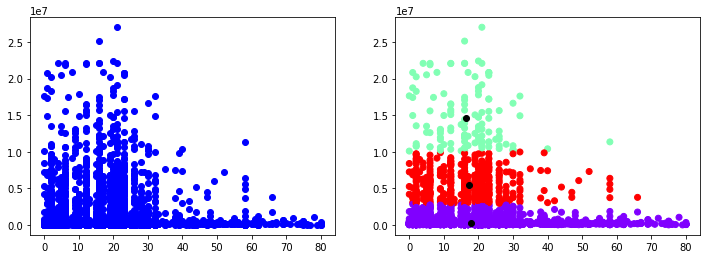

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lista[:,0], lista[:,1], c="blue", cmap='rainbow'); 
plt.subplot(122) 
plt.scatter(lista[:,0],lista[:,1], c=kmeans.labels_, cmap='rainbow')  
plt.scatter(kmeans.cluster_centers_[:,0] ,kmeans.cluster_centers_[:,1], color='black')  

A partir de la gráfica anterior, podríamos decir que si tuviéramos que clasificar tres eps GRANDES que está acorde a unos precios dados, entonces tenemos los clústeres de aquellas eps que varían sus precios según el accidente. Acá también se entra en incertidumbre ya que no se sabe qué tipo de accidente fue el que ocasionó tal costo pero sí se podría afrirmar que tienen una relación con los clústeres.


## Implementación DBScan
Con DBScan hay que tener presente que él revisa 'vecinos' cercanos, de tal manera que si cumple con el criterio podría clasificar todo como un sólo cluster, este tipo de algoritmo es más para puntos que están notablemente dispersos.


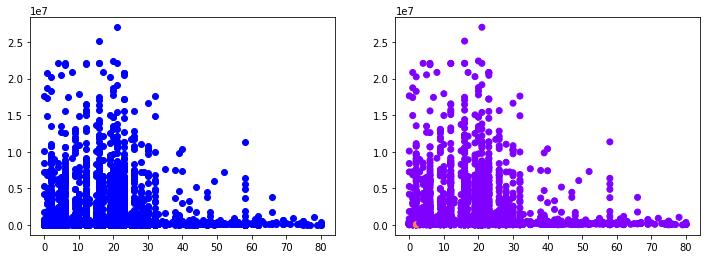

In [0]:
DBS = DBSCAN(eps=0.1)
DBS.fit(lista) 

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(lista[:,0], lista[:,1], c="blue", cmap='rainbow');
plt.subplot(122) 
plt.scatter(lista[:,0],lista[:,1], c=DBS.labels_, cmap='rainbow');

Por ende, se observa según las gráficas que DBScan toma todos los puntos como un único clúster, a diferencia de KMeans que es más útil ya que sí proporciona los clústeres solicitados.